# INSTRUCTION FINE-TUNING

## STEP 1: PREPARING DATASET

<div class="alert alert-block alert-success">

In this section, we download and format the instruction dataset for instruction finetuning a
pretrained LLM in this chapter. The dataset consists of 1100 instruction-response pairs.

The following code implements and executes a function to download this dataset, which
is a relatively small file, only 204 KB in size, in JSON format. JSON, or JavaScript Object
Notation, mirrors the structure of Python dictionaries, providing a simple structure for data
interchange that is both human-readable and machine-friendly.

</div>

In [210]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


<div class="alert alert-block alert-success">

The data list , which we loaded from the JSON file contains the 1100 entries of the
instruction dataset. 

Let's print one of the entries to see how each entry is structured:

</div>

In [211]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [212]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### CONVERTING INSTRUCTIONS INTO ALPACA FORMAT

In [213]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

<div class="alert alert-block alert-info">
    
This format_input function takes a dictionary entry as input and constructs a formatted
string.

</div>

<div class="alert alert-block alert-success">

 Let's test it to dataset entry data[50], which to looked at earlier:

</div>

In [214]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


<div class="alert alert-block alert-warning">

Note that the format_input skips the optional ### Input: section if the 'input' field is
empty, which we can test out by applying the format_input function to entry data[999]
that we inspected earlier:

</div>

In [215]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


### SPLITTING DATASET INTO TRAIN-TEST-VALIDATION

In [216]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [217]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


<div class="alert alert-block alert-warning">

Having successfully downloaded and partitioned the dataset, and gained a clear
understanding of the dataset prompt formatting, we are now ready for the core
implementation of the instruction finetuning process.

</div>

## STEP 2: ORGANIZING DATA INTO TRAINING BATCHES

<div class="alert alert-block alert-success">

In the previous chapter, the training batches were created automatically by the PyTorch
DataLoader class, which employs a default collate function to combine lists of samples into
batches. 

A collate function is responsible for taking a list of individual data samples and
merging them into a single batch that can be processed efficiently by the model during
training.

</div>

<div class="alert alert-block alert-warning">

However, the batching process for instruction finetuning in this chapter is a bit more
involved and requires us to create our own custom collate function that we will later plug
into the DataLoader. 

We implement this custom collate function to handle the specific
requirements and formatting of our instruction finetuning dataset.

</div>

<div class="alert alert-block alert-success">

First, we code an
InstructionDataset class that applies format_input from the previous section and pretokenizes all inputs in the dataset, similar to the SpamDataset in chapter 6.

</div>

In [218]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

<div class="alert alert-block alert-warning">

Similar to the approach in chapter 6, we aim to accelerate training by collecting multiple
training examples in a batch, which necessitates padding all inputs to a similar length. 

As with the previous chapter, we use the <|endoftext|> token as a padding token.
    
Instead of appending the <|endoftext|> tokens to the text inputs, we can append its
token ID to the pre-tokenized inputs directly. 

To remind us which token ID we should use,
we can use the tokenizer's .encode method on an <|endoftext|> token:

</div>

In [219]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


<div class="alert alert-block alert-warning">

In chapter 6, we padded all examples in a dataset to the same length. 

Moving on, here, we adopt a more sophisticated approach by developing a custom
collate function that we can pass to the data loader. 

This custom collate function pads the
training examples in each batch to have the same length, while allowing different batches
to have different lengths.

This approach minimizes unnecessary
padding by only extending sequences to match the longest one in each batch, not the
whole dataset.

</div>

<div class="alert alert-block alert-success">

We can implement the padding process with a custom collate
function as follows:
</div>

<div class="alert alert-block alert-info">
    
Step 1: Find the longest sequence in the batch
    
Step 2: Pad and prepare inputs
    
Step 3: Remove extra padded token added earlier

Step 4: Convert list of inputs to tensor and transfer to target device

</div>

In [220]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

<div class="alert alert-block alert-info">
    
The custom_collate_draft_1 we implemented is designed to be integrated into a PyTorch
DataLoader, but it can also function as a standalone tool. 

Here, we use it independently to
test and verify that it operates as intended. 

</div>

<div class="alert alert-block alert-success">

Let's try it on three different inputs that we
want to assemble into a batch, where each example gets padded to the same length:

</div>

In [221]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<div class="alert alert-block alert-info">
    
As we can see based on the preceding output, all inputs have been padded to the length of
the longest input list, inputs_1 containing 5 token IDs.

</div>

<div class="alert alert-block alert-warning">

So far, we have just implemented our first custom collate function to create batches from
lists of inputs. 

However, as you learned in previous lessons, we also need to create batches
with the target token IDs, corresponding to the batch of input IDs. 

These target IDs are crucial because they represent what we want the model to
generate and what we need during training to calculate the loss for the weight updates,
similar to previous chapters.

</div>

#### CREATING TARGET TOKEN IDS FOR TRAINING

<div class="alert alert-block alert-success">

Similar to the process described for pretraining an LLM, the target token IDs
match the input token IDs but are shifted one position to the right. 

This setup allows the LLM to learn how to predict the next token in a sequence.

</div>

<div class="alert alert-block alert-success">

The following updated collate function generates the target token IDs from the input token IDs:

</div>

In [222]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">
    
Step 1: Truncate the last token for inputs
                               
Step 2: Shift +1 to the right for targets

</div>

In [223]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


<div class="alert alert-block alert-info">
    
The 1st tensor represents inputs.
    
The 2nd tensor represents the targets

</div>

<div class="alert alert-block alert-success">

In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contributing to
the training loss calculation, ensuring that only meaningful data influences model learning.

In classification fine-tuning, we did not have to worry about this since we only trained the model based on
the last output token.)
</div>

<div class="alert alert-block alert-warning">

Note that we retain one end-of-text token, ID 50256, in the target list.

This allows the LLM to learn when to generate an end-of-text token
in response to instructions, which we use as an indicator that the generated response is
complete.

</div>

<div class="alert alert-block alert-success">

In the following code, we modify our custom collate function to replace tokens with ID
50256 with -100 in the target lists.

Additionally, we introduce
an allowed_max_length parameter to optionally limit the length of the samples. 

This
adjustment will be useful if you plan to work with your own datasets that exceed the 1024-
token context size supported by the GPT-2 model. 

The code for this updated collate function
is as follows:
</div>

In [224]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">
    
Step 1: Replace all but the first padding tokens in targets by ignore_index

Step 2: Optionally truncate to maximum sequence length

</div>

<div class="alert alert-block alert-success">

Again, let's try the collate function on the sample batch that we created earlier to check
that it works as intended:
</div>

In [225]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


<div class="alert alert-block alert-info">
    
The modified collate function works as expected, altering the target list by inserting the
token ID -100. 

What is the logic behind this adjustment? Let's explore the underlying
purpose of this modification.

</div>

<div class="alert alert-block alert-warning">

For demonstration purposes, consider the following simple and self-contained example
where each output logit can correspond to a potential token from the model's vocabulary.

Here's how we might calculate the cross entropy loss (introduced in chapter 5) during
training when the model predicts a sequence of tokens, similar to what we have done in
chapter 5 when pretraining the model, or in chapter 6 when finetuning the model for
classification:

</div>

In [226]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


<div class="alert alert-block alert-success">

Adding an additional token ID will, as we would expect, affect the loss calculation.
</div>

In [227]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


<div class="alert alert-block alert-success">

Now, let's get to the interesting part and see what happens if we replace the third target
token ID with -100:
</div>

In [228]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)

targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


<div class="alert alert-block alert-warning">

Based on this result, we can see that the resulting loss on these 3 training examples is
identical to the loss we calculated from the 2 training examples earlier. 

In other words, the
cross entropy loss function ignored the third entry in the targets_3 vector, the token ID
corresponding to -100. 

(Interested readers can try to replace the -100 value with another
token IDs that is not 0 or 1, and will see that this results in an error.)

</div>

<div class="alert alert-block alert-warning">

So, what's so special about -100 that it's ignored by the cross entropy loss? The default
setting of the cross entropy function in PyTorch is cross_entropy(...,
ignore_index=-100). 

This means that it ignores targets labeled with -100.

</div>

<div class="alert alert-block alert-warning">

In this chapter, we take advantage of this ignore_index to ignore the additional end-oftext (padding) tokens that we used to pad the training examples to have the same length in
each batch.

</div>

<div class="alert alert-block alert-warning">

However, we want to keep one 50256 (end-of-text)
token ID in the targets because it helps the LLM to learn to generate end-of-text tokens,
which we can use as an indicator that a response is complete.

</div>

#### MASKING TARGET TOKEN IDS

<div class="alert alert-block alert-info">
    
In addition to masking out padding tokens, it is also common to mask out the target
token IDs that correspond to the instruction

</div>

<div class="alert alert-block alert-success">

By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the generated response target
IDs. 

By masking out the instruction tokens, the model is trained to focus on generating
accurate responses rather than additionally also memorizing instructions, which can help
with reducing overfitting.
</div>

<div class="alert alert-block alert-info">
    
Currently, researchers are divided on whether masking the instructions is universally beneficial during instruction finetuning. 

For instance, a recent
paper titled "Instruction Tuning With Loss Over Instructions" demonstrated that not
masking the instructions benefits the LLM performance.

In this chapter, we do not apply masking and leave it as an optional
exercise for the reader.

</div>

## STEP 3: CREATING DATALOADERS FOR AN INSTRUCTION DATASET

<div class="alert alert-block alert-warning">

The custom_collate_fn includes code to move the input and target tensors (for
example, torch.stack(inputs_lst).to(device)) to a specified device, which can be
either "cpu" or "cuda" (for GPUs), or optionally "mps" for Macs with Apple Silicon chips.

</div>

<div class="alert alert-block alert-warning">

In previous chapters, we moved the data onto the target device (for example, the GPU
memory when device="cuda") in the main training loop. Having this as part of the collate
function offers the advantage of performing this device transfer process as a background
process outside the training loop, preventing it from blocking the GPU during model
training.

</div>

<div class="alert alert-block alert-success">

The following code initializes the device variable:
</div>

In [229]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cpu


<div class="alert alert-block alert-success">

Next, to reuse the chosen device setting in custom_collate_fn when we plug it into the
PyTorch DataLoader class later in this section, we use the partial function from Python's
functools standard library to create a new version of the function with the device
argument pre-filled. 

Additionally, we set the allowed_max_length to 1024, which truncates
the data to the maximum context length supported by the GPT-2 model we finetune later in
this chapter:
</div>

In [230]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

<div class="alert alert-block alert-success">

Next, we can set up the data loaders as we did in previous chapters, but this time we will
use our custom collate function for the batching process:
</div>

In [231]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

<div class="alert alert-block alert-success">

Let's examine the dimensions of the input and target batches generated by the training
loader:
</div>

In [232]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

<div class="alert alert-block alert-info">
    
In the preceding output, we can see that the first input and target batch have dimensions
8×61, where 8 represents the batch size, and 61 is the number of tokens in each training
example in this batch. 

The second input and target batch have a different number of
tokens, for instance, 76.


As we saw in the preceding code output, thanks to our custom collate function, the data
loader is able to create batches of different lengths. 

In the next section, we load a
pretrained LLM that we can then finetune with this data loader.

</div>

## STEP 4: LOADING A PRETRAINED LLM

<div class="alert alert-block alert-success">

Before beginning instruction finetuning, we first load a pretrained GPT model,
</div>

<div class="alert alert-block alert-warning">

Instead of using the smallest 124 million
parameter model as before, we load the medium-sized model with 355 million parameters.

The reason for this choice is that the 124 million parameter model is too limited in capacity
to achieve qualitatively satisfactory results via instruction finetuning.

</div>

<div class="alert alert-block alert-warning">

This is done using the same code as in section 5.5 of chapter 5 and section 6.4 of
the previous chapter, except that we now specify "gpt2-medium (355M)" instead of "gpt2-small
(124M)". 

Please note that executing the code provided below will initiate the download of
the medium-sized GPT model, which has a storage requirement of approximately 1.42
gigabytes. 

This is roughly three times larger than the storage space needed for the small
model:

</div>

In [233]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.index


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.meta


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/vocab.bpe


<div class="alert alert-block alert-success">

Before diving into finetuning the model in the next section, let's take a moment to assess
the pretrained LLM's performance on one of the validation tasks by comparing its output to
the expected response. 

This will give us a baseline understanding of how well the model
performs on an instruction-following task right out of the box, prior to finetuning, and will
help us appreciate the impact of finetuning later on. 

We use the first example from the
validation set for this assessment:
</div>

In [234]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [235]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

<div class="alert alert-block alert-info">
    
It's important to note that the generate function returns the combined input and output
text. 

This behavior was convenient in previous chapters since pretrained LLMs are primarily
designed as text-completion models, where the input and output are concatenated to
create a coherent and legible text. 

However, when evaluating the model's performance on a
specific task, we often want to focus solely on the model's generated response.

</div>

<div class="alert alert-block alert-success">

To isolate the model's response text, we need to subtract the length of the input
instruction from the start of the generated_text:

</div>

In [236]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


<div class="alert alert-block alert-info">

This code snippet removes the input text from the beginning of the generated_text,
leaving us with only the model's generated response. The strip() function is then applied
to remove any leading or trailing whitespace characters. The output is as follows:

</div>

<div class="alert alert-block alert-info">
    
As we can see from the output, the pretrained model is not yet capable of correctly
following the given instruction. 

While it does create a "Response" section, it simply repeats
the original input sentence and part of the instruction, failing to convert the active sentence
to passive voice as requested.


In the upcoming section, we implement the finetuning process to improve the model's
ability to comprehend and appropriately respond to such requests.

</div>

## STEP 5: FINETUNING THE LLM ON INSTRUCTION DATA

<div class="alert alert-block alert-success">

We already did all the hard work when we implemented the
instruction dataset processing at the beginning of this chapter. 

For the finetuning process
itself, we can reuse the loss calculation and training functions implemented in chapter 5
during the pretraining:
</div>

<div class="alert alert-block alert-success">

Before we begin training, let's calculate the initial loss for the training and validation sets:
</div>

#### PREVIOUSLY DEFINED FUNCTIONS WHICH WE WILL REQUIRE

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [237]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8258946418762205
Validation loss: 3.7619189739227297


<div class="alert alert-block alert-success">
With the model and data loaders prepared, we can now proceed to train the model. 

The following code sets up the training process, including initializing the optimizer, setting the
number of epochs, and defining the evaluation frequency and starting context to evaluate
generated LLM responses during training based on the first validation set instruction
(val_data[0]) we looked at earlier:

</div>

In [238]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

<div class="alert alert-block alert-info">


As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values.
    
Furthermore, based on the response text printed after each epoch, we can see that the model almost correctly follows the instruction to convert the input sentence 'The chef cooks the meal every day.' into passive voice 'The meal is prepared every day by the chef.' (We will properly format and evaluate the responses in a later section.

To get better results, we need to finetune the model for more epochs.

Finally, let's take a look at the training and validation loss curves

</div>

In [240]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

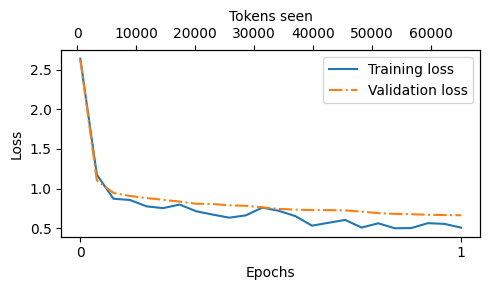

In [241]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

<div class="alert alert-block alert-info">


As we can see in the loss plot shown above, the model's performance on both the
training and validation sets improves substantially over the course of training. 

The rapid
decrease in losses during the initial phase indicates that the model is quickly learning
meaningful patterns and representations from the data. Then, as training progresses to the
second epoch, the losses continue to decrease but at a slower rate, suggesting that the
model is finetuning its learned representations and converging to a stable solution.


While the loss plot in figure 7.17 indicates that the model is training effectively, the most
crucial aspect is its performance in terms of response quality and correctness. In the
remaining sections of this chapter, we will extract the responses and store them in a format
that allows us to evaluate and quantify the response quality.

</div>

## STEP 6: EXTRACTING AND SAVING RESPONSES

<div class="alert alert-block alert-success">

After finetuning the LLM on the training portion of the instruction dataset as described in
the previous section, we now proceed to evaluate its performance on the held-out test set.
    
To accomplish this, we first extract the model-generated responses for each input in the
test dataset and collect them for manual analysis

</div>

<div class="alert alert-block alert-info">


Step 1: Iterate over the first 3 test set samples

Step 2:  Use the generate function defined earlier

</div>

<div class="alert alert-block alert-warning">

As mentioned earlier, the generate function returns the combined input and output text, so
we use slicing and the .replace() method on the generated_text contents to extract the
model's response. 

The instructions, followed by the given test set response and model
response are shown below:

</div>

In [242]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere over a region of high pressure. It typically produces a strong wind that blows across the area, creating a dense, dense cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruc

<div class="alert alert-block alert-info">


As we can see based on the test set instructions, given responses, and the model's
responses, the model performs relatively well. 

The answers to the first instruction
is clearly correct, while the second answer and the third answers are not correct. 

This is because we have done the fine-tuning for only 1 epoch due to hardware limitations. To get better results, we need to increase the epochs to at least 2.

</div>

<div class="alert alert-block alert-warning">

Most importantly, we can see that model evaluation is not as straightforward as in the
previous chapter, where we simply calculated the percentage of correct spam/non-spam
class labels to obtain the classification accuracy. 

In practice, instruction-finetuned LLMs
such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple choice benchmarks such as MMLU ("Measuring
Massive Multitask Language Understanding," https://arxiv.org/abs/2009.
03300), which test the general knowledge of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot
arena (https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval (https://tatsulab.github.io/alpaca_eval/).
completes the request.

</div>

<div class="alert alert-block alert-success">

Considering the scale of the task at hand, we will implement an approach similar to
method 3, which involves evaluating the responses automatically using another LLM. 

This
will allow us to efficiently assess the quality of the generated responses without the need
for extensive human involvement, thereby saving time and resources while still obtaining
meaningful performance indicators.
</div>

<div class="alert alert-block alert-success">

To prepare the responses for this evaluation process, we append the generated model
responses to the test_set dictionary and save the updated data as an "instructiondata-with-response.json" file for record keeping. 

Additionally, by saving this file, we can
easily load and analyze the responses in separate Python sessions later on if needed.
</div>

<div class="alert alert-block alert-success">

The following code uses the generate method in the same manner as before; however,
we now iterate over the entire test_set. 

Also, instead of printing the model responses, we
add them to the test_set dictionary:
</div>

In [244]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [18:28<00:00, 10.08s/it]


<div class="alert alert-block alert-success">

Let's verify that the responses have been correctly added to the test_set dictionary by
examining one of the entries:
</div>

In [245]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


<div class="alert alert-block alert-info">


Based on the output, we can see that the model_response has been added correctly.

</div>

<div class="alert alert-block alert-success">

Finally, we save the model as gpt2-medium355M-sft.pth file to be able to reuse it in future
projects:
</div>

In [246]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## STEP 7: EVALUATING THE FINE-TUNED LLM

<div class="alert alert-block alert-success">

Previously, we judged the performance of an instruction finetuned model by looking at its
responses on 3 examples of the test set. 

While this gives us a rough idea of how well the
model performs, this method does not really scale well to larger amounts of responses. 

So, in this section, we implement a method to automate the response evaluation of the finetuned LLM using another, larger LLM.
</div>

<div class="alert alert-block alert-success">

To implement the evaluation step which involves evaluating test set responses in
an automated fashion, we utilize an existing instruction-finetuned 8 billion parameter Llama
3 model developed by Meta AI. 

This model can be run locally using the open-source Ollama
application (https://ollama.com).
</div>

<div class="alert alert-block alert-warning">

Ollama is an efficient application for running LLMs on a laptop. 

It serves as a wrapper
around the open-source llama.cpp library (https://github.com/ggerganov/llama.cpp), which
implements LLMs in pure C/C++ to maximize efficiency. 

However, note that Ollama is only
a tool for generating text using LLMs (inference) and does not support training or finetuning
LLMs.

</div>

<div class="alert alert-block alert-success">

The following code verifies that the Ollama session is running properly before we use
Ollama to evaluate the test set responses generated in the previous section:</div>

In [247]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


<div class="alert alert-block alert-success">

An alternative to the ollama run command for interacting with the model is through its
REST API using Python. 

The following query_model function demonstrates how to use the
API:</div>

<div class="alert alert-block alert-info">


Step 1: Create the data payload as a dictionary
    
Step 2: Convert the dictionary to a JSON formatted string and encode it to bytes
    
Step 3: Create a request object, setting the method to POST and adding necessary headers
    
Step 4: Send the request and capture the response
    
</div>

In [249]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

<div class="alert alert-block alert-success">

Before running the subsequent code cells in this notebook, ensure that Ollama is still
running. The previous code cells should print "Ollama running: True" to confirm that the
model is active and ready to receive requests.
</div>

<div class="alert alert-block alert-success">

Here's an example of how to use the query_llama function we just implemented:
</div>

In [251]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

<div class="alert alert-block alert-success">

Using the query_model function defined earlier, we can evaluate the responses generated
by our finetuned model with a prompt that prompts the Llama 3 model to rate our
finetuned model's responses on a scale from 0 to 100 based on the given test set response
as reference.
</div>

<div class="alert alert-block alert-success">

First, we apply this approach to the first three examples from the test set that we
examined in a previous section:
</div>

In [252]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

<div class="alert alert-block alert-info">


Based on the generated responses, we can observe that the Llama 3 model provides
reasonable evaluations and is capable of assigning partial points when a model's answer is
not entirely correct. 
    
</div>

<div class="alert alert-block alert-info">


The previous prompt returns highly detailed evaluations in addition to the score. 

We can
modify the prompt to just generate integer scores ranging from 0 to 100, where 100
represents the best possible score. 

This modification allows us to calculate an average score
for our model, which serves as a more concise and quantitative assessment of its
performance.
</div>

<div class="alert alert-block alert-success">

The following generate_model_scores function uses a modified the prompt telling the
model to "Respond with the integer number only.":
</div>

In [255]:
for entry in test_data[:2]:
    prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
    score = query_model(prompt, model)
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt, model))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> 85

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms in the atmosphere over a region of high pressure. It typically produces a strong wind that blows across the area, creating a dense, dense cloud.

Score:
>> 20

-------------------------


In [253]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

<div class="alert alert-block alert-warning">

I am not running the above function because of hardware limitations. I am using a Macbook Air 2020.

It takes about 1 min  on a M3 Macbook Air.
</div>

<div class="alert alert-block alert-info">


When you run the above code, you will see that the evaluation output shows that our finetuned model achieves an average score above 50,
which provides a useful benchmark for comparison against other models or for
experimenting with different training configurations to improve the model's performance.

It's worth noting that Ollama is not entirely deterministic at the time of this writing,
which means that the scores you obtain might slightly vary from the ones presented above.
    
To obtain more robust results, you can repeat the evaluation multiple times and average
the resulting scores.
</div>

<div class="alert alert-block alert-warning">

To further improve our model's performance, we can explore various strategies, such as:

(1) Adjusting the hyperparameters during finetuning, such as the learning
rate, batch size, or number of epochs.


(2) Increasing the size of the training dataset or diversifying the examples to
cover a broader range of topics and styles.


(3) Experimenting with different prompts or instruction formats to guide the
model's responses more effectively.


(4) Considering the use of a larger pretrained model, which may have greater
capacity to capture complex patterns and generate more accurate
responses.

(5) We can also use parameter efficient fine-tuning techniques like LoRA.
</div>

In [256]:
## CONCLUSIONS